In [4]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import shap

from catboost import CatBoostRegressor, Pool
import pickle
import pandas as pd
import numpy as np
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold


In [5]:
train_1 = pd.read_pickle('../data/prepared_data/train_1.pkl')
train_2 = pd.read_pickle('../data/prepared_data/train_2.pkl')

In [6]:
dataset_1 = train_1.drop(columns='Timestamp')
dataset_2 = train_2.drop(columns='Timestamp')

TARGET = 'label'
dataset_1.shape, dataset_2.shape

((54000, 226), (230400, 226))

In [7]:
with open('../models/catboost_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Tree-based (or Gini) feature importance 

<Axes: >

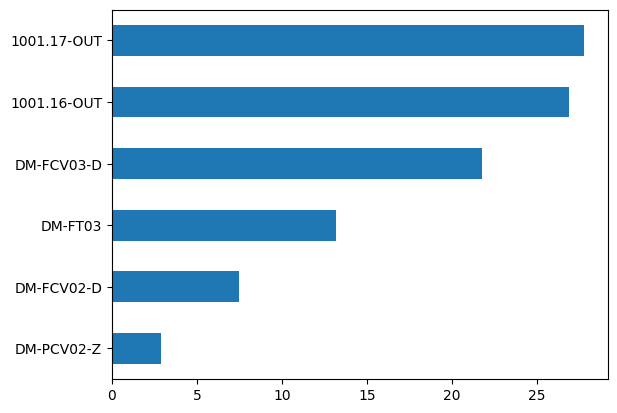

In [8]:
X_test = dataset_2.drop(columns=TARGET)
y_test = dataset_2[TARGET]

fi = pd.Series(index=X_test.columns, data=model.get_feature_importance())
fi.sort_values(inplace=True)
gini_fi = fi[fi > 0]
gini_fi.plot.barh()

# Permutation Importance

<Axes: >

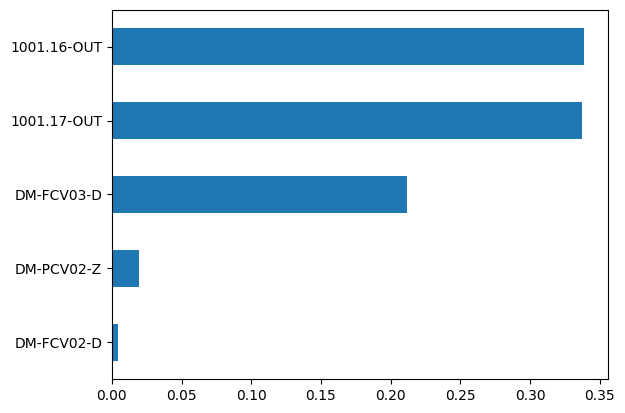

In [9]:
X_test = dataset_1.drop(columns=TARGET)
y_test = dataset_1[TARGET]

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066, n_jobs=-1, scoring='f1')
fi = pd.Series(index=X_test.columns, data=perm_importance.importances_mean)
fi.sort_values(inplace=True)
permutations_fi = fi[fi > 0]
permutations_fi.plot.barh()

# SHAP

<Axes: >

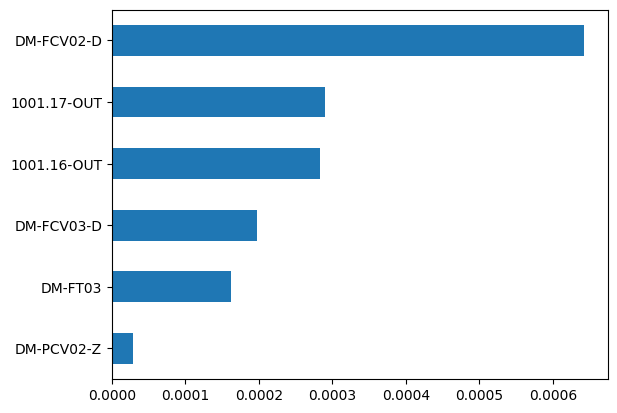

In [10]:
X_test = dataset_1.drop(columns=TARGET)
y_test = dataset_1[TARGET]

explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap_importance = shap_values.abs.mean(0).values

fi = pd.Series(index=X_test.columns, data=shap_importance)
fi.sort_values(inplace=True)
shap_fi = fi[fi > 0]
shap_fi.plot.barh()

In [11]:
top_fi = list(set(gini_fi.index.tolist() + permutations_fi.index.tolist() + shap_fi.index.tolist()))
top_fi

['DM-FT03',
 '1001.16-OUT',
 '1001.17-OUT',
 'DM-PCV02-Z',
 'DM-FCV03-D',
 'DM-FCV02-D']

In [13]:
train_1[top_fi + [TARGET] + ['Timestamp']].to_pickle('../data/prepared_data/train_1_fi.pkl')
train_2[top_fi + [TARGET] + ['Timestamp']].to_pickle('../data/prepared_data/train_2_fi.pkl')